In [1]:
import numpy as np
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

# Cost and Observations

### Experiment 1: Put the entire criteria dictionary into the prompt (25 criteria to be evaluated by each run of the quantifier). Running the LLM quantifier over 120 samples * 50 seeds (=6000 queries), took about 27 hours, average about 16 seconds per query. However, the returned data quality is poor. Out of 6000 queries, we got 3729 incomplete returned results.

### Note: I started off using variances, but for problem type which has a large range of accepted values and the index do not necessarily reflect any useful ordering, it will have a large variance even though the estimates are generally close enough.

### Note: After analyzing the change in standard deviations, at 18 seeds we seem to be able to achieve a balance between cost and data quality.

### Note: "terminology" has a stdev of 0, but it is always returning the same value across all samples, which means the quantifier is not rating this criterion properly.

### Criterion Selection: Looking at the standard deviations plots, the quantifier likely did well for criterion like 'response_time', 'problem_type', 'problem_level' where it returns consistent results for most samples. However these criterion do not necessarly reflect what is useful for the task.

### Experiment 2 Idea (TODO): Evaluate only one criterion per prompt. Can try incorporate one pair of synthetic data for each criterion to replace the task successful and failed example in the prompt.

### Experiment 3 Idea (TODO): Return code to evaluate criterion. Compare quality against experiment 2.

# Load Criteria

In [2]:
# load the criteria
criteria_file_path = "output/final_filtered_criteria.json"
with open(criteria_file_path) as crit_file:
    criteria = json.load(crit_file)

criteria

{'efficiency': {'description': 'The conciseness of the solution and the use of the most efficient method to solve the problem.',
  'accepted_values': ['inefficient',
   'moderately_efficient',
   'highly_efficient']},
 'accuracy': {'description': 'The correctness of the solution provided for the math problem.',
  'accepted_values': ['0% - Completely incorrect',
   '25% - Partially correct',
   '50% - Mostly correct',
   '75% - Almost correct',
   '100% - Completely correct']},
 'completeness': {'description': 'The extent to which the solution covers all aspects of the problem.',
  'accepted_values': ['0% - Not complete',
   '25% - Partially complete',
   '50% - Mostly complete',
   '75% - Almost complete',
   '100% - Fully complete']},
 'clarity': {'description': 'The ease with which the solution can be understood by the target audience.',
  'accepted_values': ['0% - Not clear',
   '25% - Somewhat clear',
   '50% - Fairly clear',
   '75% - Mostly clear',
   '100% - Very clear']},
 'pre

In [3]:
# convert accepted value to score
level2score = {}
level2criterion = {}
for criterion in criteria:
     score = 0
     for v in criteria[criterion]["accepted_values"]:
        level2score[v] = score
        level2criterion[v] = criterion
        score += 1
print(level2score)
print(level2criterion)

{'inefficient': 0, 'moderately_efficient': 1, 'highly_efficient': 2, '0% - Completely incorrect': 0, '25% - Partially correct': 1, '50% - Mostly correct': 2, '75% - Almost correct': 3, '100% - Completely correct': 4, '0% - Not complete': 0, '25% - Partially complete': 1, '50% - Mostly complete': 2, '75% - Almost complete': 3, '100% - Fully complete': 4, '0% - Not clear': 0, '25% - Somewhat clear': 1, '50% - Fairly clear': 2, '75% - Mostly clear': 3, '100% - Very clear': 4, 'poor': 0, 'fair': 1, 'excellent': 2, '0% - No steps delineated': 0, '25% - Few steps delineated': 1, '50% - Some steps delineated': 2, '75% - Most steps delineated': 3, '100% - All steps delineated': 4, '0-15 sec': 0, '16-30 sec': 1, '31-60 sec': 2, '1-3 min': 3, '3-5 min': 4, '>5 min': 5, 'inconsistent': 0, 'mostly consistent': 1, 'consistent': 2, 'none': 0, 'some steps': 1, 'half steps': 2, 'most steps': 3, 'all steps': 4, 'Ignored all errors': 0, 'Handled very few errors': 1, 'Handled some errors': 2, 'Handled mo

# Experiment 1: All 25 criteria in one prompt

In [4]:
num_outputs = 120
num_seeds = 50

results = defaultdict(lambda: defaultdict(list)) # result[criterion][game] gives a list of 50 scores for that game 

incomplete_dict_error_count = 0
quantified_result_errors = defaultdict(lambda: defaultdict(str))

for seed in range(num_seeds):
    # Load outcome data for the current seed
    with open(f'output/old/evaluated_problems-{seed}.json', 'r') as file:
        outcome = json.load(file)

        for game in outcome:
            gameid = game.strip(".json")
            # some of these output are ill-formatted, so we have some if statements to do hardcoded data cleansing
            quantified_string_cleaned = outcome[game]['estimated_performance'].strip().replace("'", '"').rstrip("}").rstrip().rstrip(",") + "}"
            try:
                quantified_result = json.loads(quantified_string_cleaned)
                if len(quantified_result) < 25:
                    incomplete_dict_error_count += 1
                for criterion in quantified_result:
                    result_criterion = criterion.strip()
                    results[level2criterion[quantified_result[criterion]]][gameid].append(level2score[quantified_result[criterion]])
            except:
                quantified_result_errors[gameid][seed] = quantified_string_cleaned
                incomplete_dict_error_count += 1

In [5]:
print(incomplete_dict_error_count)

3729


## Sample Standard Deviations

In [6]:
stdevs = defaultdict(lambda: defaultdict(float))

for criterion in results:
    for game in results[criterion]:
        if len(results[criterion][game]) < 2:
            continue
        stdevs[criterion][game] = statistics.stdev(results[criterion][game])

## Present the Statistics

### print average sample standard deviations for each criterion

In [7]:
stdevs_list = {}
for criterion in stdevs:
    stdevs_list[criterion] = []
    for game in stdevs[criterion]:
        stdevs_list[criterion].append(stdevs[criterion][game])

In [8]:
sorted_stdevs = sorted(stdevs_list.items(), key=lambda x:statistics.mean(x[1]), reverse=True)

for entry in sorted_stdevs:
    print(f"criterion {entry[0]}: {statistics.mean(entry[1])}, number of data points: {len(entry[1])}")

criterion problem type: 1.3711994117229016, number of data points: 94
criterion step explanation: 0.7490392831766559, number of data points: 119
criterion steps delineation: 0.7080020466448206, number of data points: 119
criterion level appropriateness: 0.7014263860689548, number of data points: 119
criterion simplification: 0.6754983225939353, number of data points: 119
criterion error handling: 0.6542288604531991, number of data points: 119
criterion clarity: 0.6398683773937351, number of data points: 119
criterion completeness: 0.6383332411583479, number of data points: 119
criterion correct reasoning: 0.6350130882449205, number of data points: 95
criterion solution depth: 0.566667348444929, number of data points: 119
criterion accuracy: 0.553079317824314, number of data points: 119
criterion adaptability: 0.5530419364878648, number of data points: 119
criterion efficiency: 0.4386687328899392, number of data points: 119
criterion creativity: 0.4072243511654448, number of data points

### plot sample standard deviations for each criterion

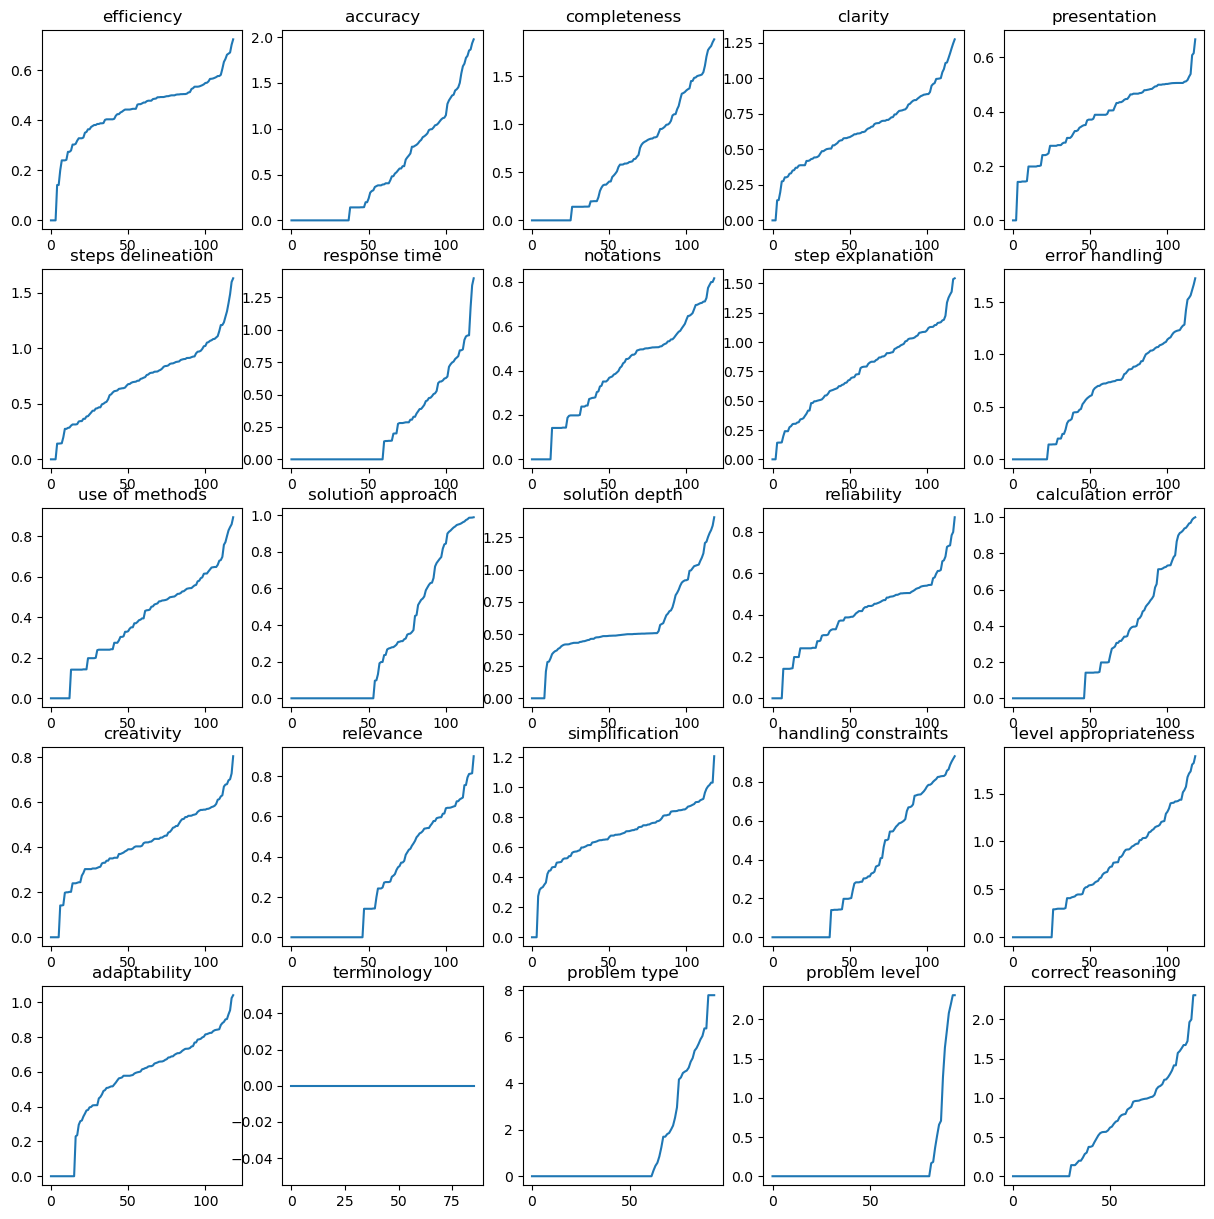

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for index, criterion in enumerate(stdevs_list):
    axs[index//5, index%5].plot(sorted(stdevs_list[criterion]))
    axs[index//5, index%5].title.set_text(criterion)


## Check the "optimal" number of seeds

In [10]:
def get_mean_stdev_for_num_seeds_exp1(num_seeds):
    results = defaultdict(lambda: defaultdict(list)) # result[criterion][game] gives a list of num_seeds scores for that game 
    
    for seed in range(num_seeds):
        # Load outcome data for the current seed
        with open(f'output/old/evaluated_problems-{seed}.json', 'r') as file:
            outcome = json.load(file)
        
            for game in outcome:
                gameid = game.strip(".json")
                # some of these output are ill-formatted, so we have some if statements to do hardcoded data cleansing
                quantified_string_cleaned = outcome[game]['estimated_performance'].strip().replace("'", '"').rstrip("}").rstrip().rstrip(",") + "}"
                try:
                    quantified_result = json.loads(quantified_string_cleaned)
                    if len(quantified_result) < 25:
                        incomplete_dict_error_count += 1
                    for criterion in quantified_result:
                        result_criterion = criterion.strip()
                        try:
                            results[level2criterion[quantified_result[criterion]]][gameid].append(level2score[quantified_result[criterion]])
                        except:
                            pass
                except:
                    pass
        
    stdevs = defaultdict(lambda: defaultdict(float))
    
    for criterion in results:
        for game in results[criterion]:
            if len(results[criterion][game]) < 2:
                continue
            stdevs[criterion][game] = statistics.stdev(results[criterion][game])
        
    stdevs_list = {}
    for criterion in stdevs:
        stdevs_list[criterion] = []
        for game in stdevs[criterion]:
            stdevs_list[criterion].append(stdevs[criterion][game])

    mean_stdevs = {}
    for criterion in stdevs_list:
        mean_stdevs[criterion] = statistics.mean(stdevs_list[criterion])

    return mean_stdevs

In [11]:
# check when is the ordering of the mean sample standard deviations stable
for num_seeds in range(5, 50):
    prev_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds - 1)
    cur_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds)

    sorted_prev_stdevs = [i[0] for i in sorted(prev_stdevs.items(), key=lambda x:x[1])]
    sorted_cur_stdevs = [i[0] for i in sorted(cur_stdevs.items(), key=lambda x:x[1])]

    if sorted_prev_stdevs == sorted_cur_stdevs:
        print(num_seeds)


8
17
18
20
24
29
30
34
35
39
41
42
43
44
46
47
48
49


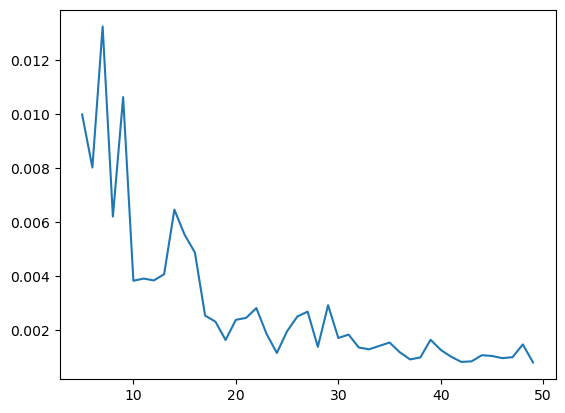

In [12]:
# check when is the biggest change in mean sample standard deviations small enough (excluding problem_type)
average_change_in_mean_stdevs = {}

for num_seeds in range(5, 50):
    prev_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds - 1)
    cur_stdevs = get_mean_stdev_for_num_seeds_exp1(num_seeds)

    change_in_mean_stdevs = {}

    for criterion in prev_stdevs:
        if criterion == "problem type":
            continue
        change_in_mean_stdevs[criterion] = cur_stdevs[criterion] - prev_stdevs[criterion]

    sorted_change_in_mean_stdevs = [abs(i[1]) for i in sorted(change_in_mean_stdevs.items(), key=lambda x: abs(x[1]), reverse=True)]

    average_change_in_mean_stdevs[num_seeds] = statistics.mean(sorted_change_in_mean_stdevs)

plt.plot(average_change_in_mean_stdevs.keys(), average_change_in_mean_stdevs.values())

## Investigate Terminology

In [13]:
level_count = defaultdict(int)
for game in results['terminology']:
    for estimate in results['terminology'][game]:
        level_count[estimate] += 1
print(level_count)

defaultdict(<class 'int'>, {1: 1432})


### Terminology has a stdev of 0, but it is always returning the same value across all samples, which means the quantifier is not rating this criterion properly.